**Referred**
1. https://torchtext.readthedocs.io/en/latest/index.html
2. https://github.com/bentrevett/pytorch-sentiment-analysis

**Dataset**
* https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

# Get Data



In [0]:
import os
os.environ["KAGGLE_USERNAME"]="ubamba98"
os.environ["KAGGLE_KEY"]=""

In [2]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/471k [00:00<?, ?B/s]
100% 471k/471k [00:00<00:00, 65.8MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 38.1MB/s]
  0% 0.00/1.21M [00:00<?, ?B/s]
100% 1.21M/1.21M [00:00<00:00, 40.0MB/s]


In [0]:
import pandas as pd
import torch
import torchtext
from torch import nn
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchtext.data import Field, TabularDataset, Dataset, Example, LabelField
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
## GLOBAL VAR
BATCH_SIZE = 512

# Dataset

```
The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

```

In [0]:
train = pd.read_csv("train.tsv.zip", sep='\t')
test = pd.read_csv("test.tsv.zip", sep='\t')

In [6]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
train.drop(columns=["PhraseId","SentenceId"], inplace = True)

In [8]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [0]:
test.drop(columns=["SentenceId"], inplace = True)

In [0]:
train, val = train_test_split(train, test_size=.33, random_state=33)
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

In [11]:
print("Train:")
train = pd.read_csv("train.csv")
print(train.head())
print("\nVal:")
val = pd.read_csv("val.csv")
print(val.head())
print("\nTest:")
test = pd.read_csv("test.csv")
print(test.head())


Train:
                           Phrase  Sentiment
0  the aisles for bathroom breaks          2
1         added clout to this doc          3
2                     the process          2
3                   Ms. Shreve 's          2
4                     madness and          2

Val:
                                              Phrase  Sentiment
0              fart jokes , masturbation jokes , and          1
1  This cinema verite speculation on the assassin...          1
2                                 's pleasant enough          3
3   Its and pieces of The Hot Chick are so hilarious          3
4                                      its content ,          2

Test:
   PhraseId                                             Phrase
0    156061  An intermittently pleasing but mostly routine ...
1    156062  An intermittently pleasing but mostly routine ...
2    156063                                                 An
3    156064  intermittently pleasing but mostly routine effort
4    156065

# Bulid Vocab

In [0]:
Phrase=Field(sequential=True, lower=True, tokenize='spacy', init_token="<start>", eos_token="<end>", batch_first=True)
Sentiment=Field(sequential=False, batch_first=True, unk_token=None)
test_ID = Field(use_vocab=False, sequential=False)

In [0]:
fields_train_val= [
    ('Phrase', Phrase), 
    ('Sentiment', Sentiment)
]
fields_test=[
    ('PhraseId', test_ID),
    ('Phrase', Phrase), 
]

In [0]:
train, val = TabularDataset.splits(path="./", train="train.csv", validation="val.csv", format="csv", fields=fields_train_val, skip_header=True)
test = TabularDataset(path="./test.csv", format="csv", fields=fields_test, skip_header=True)

In [15]:
print(f'Number of training examples: {len(train)}')
print(f'Number of validation examples: {len(val)}')
print(f'Number of testing examples: {len(test)}')

Number of training examples: 104560
Number of validation examples: 51500
Number of testing examples: 66292


In [16]:
Phrase.build_vocab(train, val, test, vectors="glove.6B.300d")
Sentiment.build_vocab(train, val)

.vector_cache/glove.6B.zip: 862MB [00:43, 19.9MB/s]                           
100%|█████████▉| 399416/400000 [00:52<00:00, 7859.62it/s]

In [17]:
print(f"Unique tokens in Phrase vocabulary: {len(Phrase.vocab)}")
print(f"Unique tokens in Sentiment vocabulary: {len(Sentiment.vocab)}")

Unique tokens in Phrase vocabulary: 17970
Unique tokens in Sentiment vocabulary: 5


In [0]:
train_iterator, valid_iterator = torchtext.data.BucketIterator.splits(
    (train, val), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.Phrase),
    device = device)

In [0]:
test_iterator = torchtext.data.BucketIterator(
                  test, 
                  batch_size = BATCH_SIZE,
                  sort_key=None,
                  device = device)

In [0]:
vocab_vector = Phrase.vocab.vectors

In [0]:
padding_idx = Phrase.vocab.stoi["<pad>"]

# Model

In [0]:
class LSTM_Model(nn.Module):
  def __init__(self, vocab_vector, hidden_dim, output_dim, num_layers=1, dropout=0.0, padding_idx=None):
    super().__init__()

    self.embedding = nn.Embedding.from_pretrained(vocab_vector, padding_idx=padding_idx)
    embedding_dim = vocab_vector.shape[1]
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
    self.dropout = nn.Dropout(p=dropout)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, text):
    embedded = self.embedding(text)
    output, hidden = self.lstm(embedded)
    h, c = hidden
    h = self.dropout(h)
    return self.fc(h[-1, :, :])

In [0]:
model = LSTM_Model(vocab_vector=vocab_vector, hidden_dim=100, output_dim=5, num_layers=2, padding_idx=padding_idx)
model = model.to(device)

In [24]:
print(model)

LSTM_Model(
  (embedding): Embedding(17970, 300, padding_idx=1)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.0)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)


# Loss

In [0]:
criterion = nn.CrossEntropyLoss()

# Test Model

In [26]:
it = iter(train_iterator)
sample_batched = next(it)
phrase = sample_batched.Phrase.to(device)
senti = sample_batched.Sentiment.to(device, dtype=torch.long)
outputs = model(phrase)
print("Sample Loss =", criterion(outputs, senti).cpu().detach().numpy()) ## ln(5) = 1.6

Sample Loss = 1.6246424


# Train

In [0]:
def train_fn(model, train_iterator, val_iterator, opt, criterion, epochs, best_acc=0, initial_epoch=0, NAME="base_model"):
  

  for e in range(initial_epoch, epochs):
    

    prediction = []
    y_true = []
    
    running_loss = 0
    model.train()
    
    for i_batch, sample_batched in enumerate(train_iterator):

      ## get_data
      phrase = sample_batched.Phrase.to(device)
      senti = sample_batched.Sentiment.to(device, dtype=torch.long)

      opt.zero_grad()
      outputs = model(phrase)           ## get_prediction

      loss = criterion(outputs, senti)
      prediction.append(outputs.cpu().detach().numpy())
      y_true.append(senti.cpu().detach().numpy())

      running_loss += loss.item()
      loss.backward()
      opt.step()
          
    running_loss = round(running_loss / (i_batch+1), 3)
    prediction = np.argmax(flatten_list(prediction).reshape(-1, 5), axis=-1)
    y_true = flatten_list(y_true)
    train_acc = round(metrics.accuracy_score(y_true, prediction), 3)
    
    history['train']['loss'].append(running_loss)
    history['train']['acc'].append(train_acc)
    
    

    ###########################################################################
    ################################VALIDATION#################################
    ###########################################################################
    
    model.eval()
    predictions = []
    y_val = []
    for i, x_batch in enumerate(val_iterator):
        phrase = sample_batched.Phrase
        senti = sample_batched.Sentiment
        pred = model(phrase.to(device)).cpu().detach().numpy()
        predictions.append(pred)
        y_val.append(senti.cpu().detach().numpy())

    predictions = flatten_list(predictions).reshape(-1, 5)
    y_val = flatten_list(y_val).reshape(-1, 1)
    loss = round(criterion(torch.FloatTensor(predictions).to(device), torch.Tensor(y_val.squeeze()).to(device, dtype=torch.long)).item(), 3)
    predictions = np.argmax(predictions, axis=-1)
    val_acc = round(metrics.accuracy_score(y_val, predictions), 3)
    
    history['val']['loss'].append(loss)
    history['val']['acc'].append(val_acc)
    
    if (e+1)%10==0:
      print(f"\nEpoch {e+1}/{epochs}: ")
      print(f"Training Loss: {running_loss}, Training Accuracy: {train_acc}")
      print(f"Validation loss: {loss}, Val accuracy: {val_acc}")

    if val_acc > best_acc:
      print("Saving model checkpoint as", val_acc, "is more than", best_acc)
      best_acc = val_acc
      torch.save({
            'history': history,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            }, f'{NAME}.epoch_{e+1}.val_acc_{val_acc}.bin')

In [0]:
def flatten_list(list_of_lists):
  return np.array([val for sublist in list_of_lists for val in sublist])

In [0]:
def init_his():
  return {
      'train': { 'loss': [], 'acc': [] }, 
      'val': { 'loss': [], 'acc': [] } 
  }

In [0]:
def draw_plots(NAME, history):
  fig = plt.figure(figsize=(8,4))
  plt.subplot(1, 2, 1)
  plt.plot(range(len(history['train']['acc'])), history['train']['acc'], label='Training Accuracy')
  plt.plot(range(len(history['val']['acc'])), history['val']['acc'], label='Testing Accuracy')
  plt.legend(loc='best')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(range(len(history['train']['loss'])), history['train']['loss'], label='Training loss')
  plt.plot(range(len(history['val']['loss'])), history['val']['loss'], label='Testing loss')
  plt.legend(loc='best')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.title('loss')
  fig.savefig(NAME+'.jpg')
  plt.show()

### Hyper  Parameter search

In [0]:
learning_rates = np.linspace(1e-4, 5e-2, 3)
dropouts = [0.25, 0.5]
num_layers = [1, 2]
hidden_size =  [64, 128]



CONFIG: lr_0.0001.dropout_0.25.num_layer_1.hidden_dim_64 

Saving model checkpoint as 0.488 is more than 0
Saving model checkpoint as 0.49 is more than 0.488
Saving model checkpoint as 0.531 is more than 0.49
Saving model checkpoint as 0.533 is more than 0.531
Saving model checkpoint as 0.555 is more than 0.533
Saving model checkpoint as 0.586 is more than 0.555

Epoch 10/30: 
Training Loss: 1.121, Training Accuracy: 0.548
Validation loss: 1.175, Val accuracy: 0.52
Saving model checkpoint as 0.623 is more than 0.586

Epoch 20/30: 
Training Loss: 1.044, Training Accuracy: 0.574
Validation loss: 1.141, Val accuracy: 0.554

Epoch 30/30: 
Training Loss: 1.003, Training Accuracy: 0.585
Validation loss: 0.995, Val accuracy: 0.578


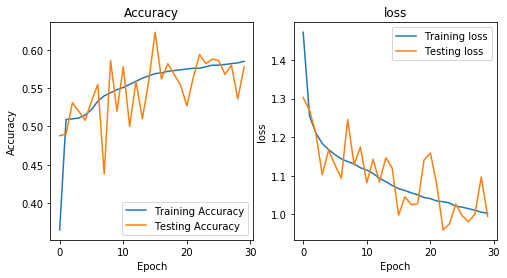



CONFIG: lr_0.0001.dropout_0.5.num_layer_1.hidden_dim_64 

Saving model checkpoint as 0.531 is more than 0
Saving model checkpoint as 0.537 is more than 0.531
Saving model checkpoint as 0.543 is more than 0.537
Saving model checkpoint as 0.562 is more than 0.543

Epoch 10/30: 
Training Loss: 1.123, Training Accuracy: 0.548
Validation loss: 1.067, Val accuracy: 0.561
Saving model checkpoint as 0.588 is more than 0.562
Saving model checkpoint as 0.607 is more than 0.588

Epoch 20/30: 
Training Loss: 1.047, Training Accuracy: 0.574
Validation loss: 1.025, Val accuracy: 0.59
Saving model checkpoint as 0.616 is more than 0.607

Epoch 30/30: 
Training Loss: 1.009, Training Accuracy: 0.584
Validation loss: 1.026, Val accuracy: 0.555


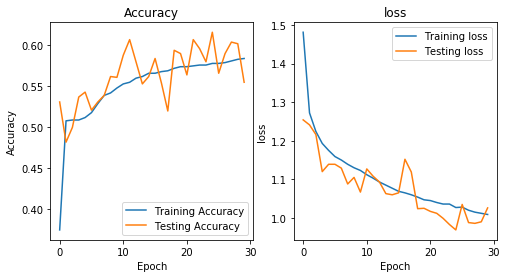



CONFIG: lr_0.0001.dropout_0.25.num_layer_1.hidden_dim_128 

Saving model checkpoint as 0.509 is more than 0
Saving model checkpoint as 0.554 is more than 0.509
Saving model checkpoint as 0.571 is more than 0.554
Saving model checkpoint as 0.58 is more than 0.571

Epoch 10/30: 
Training Loss: 1.061, Training Accuracy: 0.57
Validation loss: 1.052, Val accuracy: 0.58
Saving model checkpoint as 0.582 is more than 0.58
Saving model checkpoint as 0.605 is more than 0.582
Saving model checkpoint as 0.615 is more than 0.605
Saving model checkpoint as 0.617 is more than 0.615

Epoch 20/30: 
Training Loss: 0.992, Training Accuracy: 0.594
Validation loss: 0.99, Val accuracy: 0.574
Saving model checkpoint as 0.637 is more than 0.617
Saving model checkpoint as 0.65 is more than 0.637
Saving model checkpoint as 0.75 is more than 0.65

Epoch 30/30: 
Training Loss: 0.927, Training Accuracy: 0.623
Validation loss: 0.889, Val accuracy: 0.643


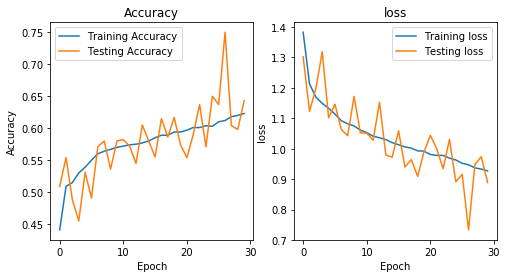



CONFIG: lr_0.0001.dropout_0.5.num_layer_1.hidden_dim_128 

Saving model checkpoint as 0.48 is more than 0
Saving model checkpoint as 0.502 is more than 0.48
Saving model checkpoint as 0.518 is more than 0.502
Saving model checkpoint as 0.535 is more than 0.518
Saving model checkpoint as 0.543 is more than 0.535
Saving model checkpoint as 0.596 is more than 0.543

Epoch 10/30: 
Training Loss: 1.071, Training Accuracy: 0.568
Validation loss: 1.041, Val accuracy: 0.572
Saving model checkpoint as 0.602 is more than 0.596
Saving model checkpoint as 0.617 is more than 0.602
Saving model checkpoint as 0.643 is more than 0.617

Epoch 20/30: 
Training Loss: 0.996, Training Accuracy: 0.587
Validation loss: 1.02, Val accuracy: 0.634
Saving model checkpoint as 0.645 is more than 0.643
Saving model checkpoint as 0.652 is more than 0.645

Epoch 30/30: 
Training Loss: 0.907, Training Accuracy: 0.629
Validation loss: 0.893, Val accuracy: 0.625


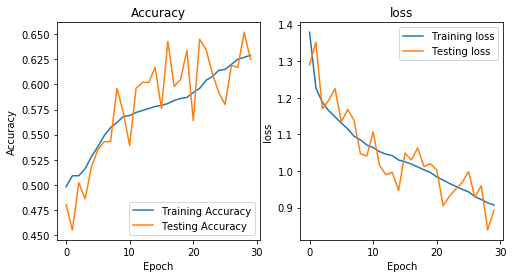



CONFIG: lr_0.0001.dropout_0.25.num_layer_2.hidden_dim_64 

Saving model checkpoint as 0.5 is more than 0
Saving model checkpoint as 0.531 is more than 0.5
Saving model checkpoint as 0.559 is more than 0.531
Saving model checkpoint as 0.566 is more than 0.559
Saving model checkpoint as 0.58 is more than 0.566

Epoch 10/30: 
Training Loss: 1.086, Training Accuracy: 0.563
Validation loss: 1.068, Val accuracy: 0.553
Saving model checkpoint as 0.598 is more than 0.58
Saving model checkpoint as 0.609 is more than 0.598
Saving model checkpoint as 0.617 is more than 0.609

Epoch 20/30: 
Training Loss: 0.971, Training Accuracy: 0.604
Validation loss: 0.936, Val accuracy: 0.631
Saving model checkpoint as 0.631 is more than 0.617
Saving model checkpoint as 0.652 is more than 0.631
Saving model checkpoint as 0.656 is more than 0.652
Saving model checkpoint as 0.66 is more than 0.656

Epoch 30/30: 
Training Loss: 0.907, Training Accuracy: 0.631
Validation loss: 0.821, Val accuracy: 0.625


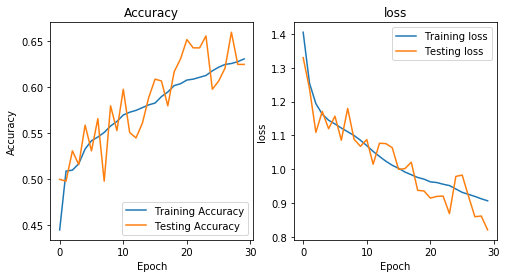



CONFIG: lr_0.0001.dropout_0.5.num_layer_2.hidden_dim_64 

Saving model checkpoint as 0.514 is more than 0
Saving model checkpoint as 0.574 is more than 0.514

Epoch 10/30: 
Training Loss: 1.096, Training Accuracy: 0.558
Validation loss: 1.115, Val accuracy: 0.549
Saving model checkpoint as 0.609 is more than 0.574
Saving model checkpoint as 0.616 is more than 0.609

Epoch 20/30: 
Training Loss: 0.984, Training Accuracy: 0.597
Validation loss: 1.016, Val accuracy: 0.566
Saving model checkpoint as 0.625 is more than 0.616
Saving model checkpoint as 0.634 is more than 0.625
Saving model checkpoint as 0.67 is more than 0.634

Epoch 30/30: 
Training Loss: 0.917, Training Accuracy: 0.625
Validation loss: 0.897, Val accuracy: 0.635


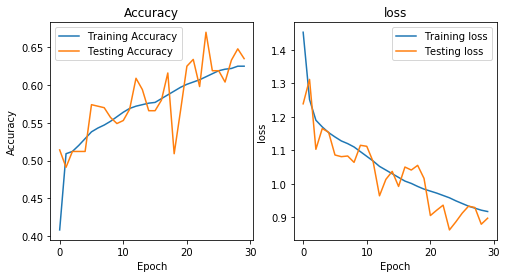



CONFIG: lr_0.0001.dropout_0.25.num_layer_2.hidden_dim_128 

Saving model checkpoint as 0.518 is more than 0
Saving model checkpoint as 0.527 is more than 0.518
Saving model checkpoint as 0.553 is more than 0.527
Saving model checkpoint as 0.568 is more than 0.553
Saving model checkpoint as 0.571 is more than 0.568
Saving model checkpoint as 0.59 is more than 0.571

Epoch 10/30: 
Training Loss: 0.976, Training Accuracy: 0.602
Validation loss: 0.909, Val accuracy: 0.631
Saving model checkpoint as 0.631 is more than 0.59
Saving model checkpoint as 0.652 is more than 0.631

Epoch 20/30: 
Training Loss: 0.871, Training Accuracy: 0.637
Validation loss: 0.848, Val accuracy: 0.631
Saving model checkpoint as 0.661 is more than 0.652
Saving model checkpoint as 0.668 is more than 0.661
Saving model checkpoint as 0.703 is more than 0.668

Epoch 30/30: 
Training Loss: 0.81, Training Accuracy: 0.661
Validation loss: 0.801, Val accuracy: 0.662


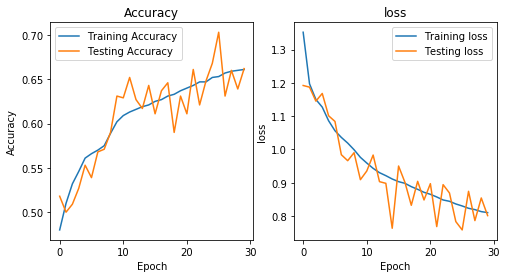



CONFIG: lr_0.0001.dropout_0.5.num_layer_2.hidden_dim_128 

Saving model checkpoint as 0.535 is more than 0
Saving model checkpoint as 0.58 is more than 0.535
Saving model checkpoint as 0.584 is more than 0.58
Saving model checkpoint as 0.586 is more than 0.584

Epoch 10/30: 
Training Loss: 1.003, Training Accuracy: 0.581
Validation loss: 0.939, Val accuracy: 0.613
Saving model checkpoint as 0.613 is more than 0.586
Saving model checkpoint as 0.641 is more than 0.613
Saving model checkpoint as 0.643 is more than 0.641

Epoch 20/30: 
Training Loss: 0.884, Training Accuracy: 0.633
Validation loss: 0.932, Val accuracy: 0.609
Saving model checkpoint as 0.658 is more than 0.643
Saving model checkpoint as 0.67 is more than 0.658
Saving model checkpoint as 0.684 is more than 0.67

Epoch 30/30: 
Training Loss: 0.82, Training Accuracy: 0.66
Validation loss: 0.874, Val accuracy: 0.643


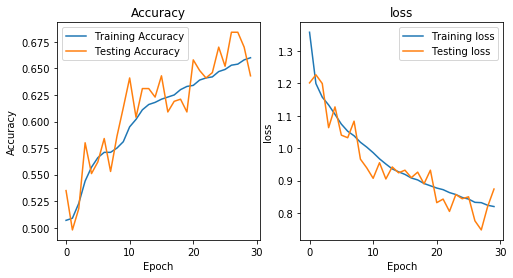



CONFIG: lr_0.02505.dropout_0.25.num_layer_1.hidden_dim_64 

Saving model checkpoint as 0.629 is more than 0
Saving model checkpoint as 0.637 is more than 0.629
Saving model checkpoint as 0.688 is more than 0.637
Saving model checkpoint as 0.699 is more than 0.688
Saving model checkpoint as 0.744 is more than 0.699

Epoch 10/30: 
Training Loss: 0.752, Training Accuracy: 0.687
Validation loss: 0.717, Val accuracy: 0.727
Saving model checkpoint as 0.768 is more than 0.744

Epoch 20/30: 
Training Loss: 0.703, Training Accuracy: 0.711
Validation loss: 0.562, Val accuracy: 0.786
Saving model checkpoint as 0.786 is more than 0.768

Epoch 30/30: 
Training Loss: 1.281, Training Accuracy: 0.506
Validation loss: 1.255, Val accuracy: 0.543


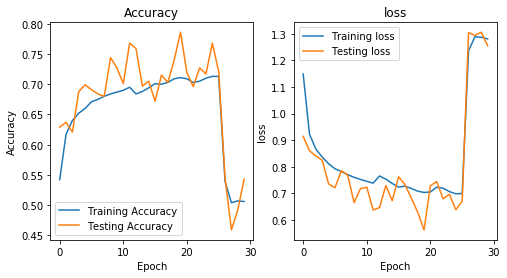



CONFIG: lr_0.02505.dropout_0.5.num_layer_1.hidden_dim_64 

Saving model checkpoint as 0.541 is more than 0
Saving model checkpoint as 0.627 is more than 0.541
Saving model checkpoint as 0.666 is more than 0.627
Saving model checkpoint as 0.688 is more than 0.666
Saving model checkpoint as 0.714 is more than 0.688

Epoch 10/30: 
Training Loss: 0.787, Training Accuracy: 0.672
Validation loss: 0.729, Val accuracy: 0.678

Epoch 20/30: 
Training Loss: 1.353, Training Accuracy: 0.491
Validation loss: 1.309, Val accuracy: 0.502

Epoch 30/30: 
Training Loss: 1.279, Training Accuracy: 0.507
Validation loss: 1.264, Val accuracy: 0.521


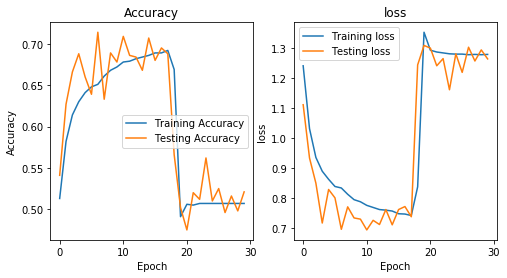



CONFIG: lr_0.02505.dropout_0.25.num_layer_1.hidden_dim_128 

Saving model checkpoint as 0.586 is more than 0
Saving model checkpoint as 0.627 is more than 0.586
Saving model checkpoint as 0.637 is more than 0.627
Saving model checkpoint as 0.646 is more than 0.637
Saving model checkpoint as 0.68 is more than 0.646
Saving model checkpoint as 0.786 is more than 0.68

Epoch 10/30: 
Training Loss: 0.744, Training Accuracy: 0.69
Validation loss: 0.709, Val accuracy: 0.703

Epoch 20/30: 
Training Loss: 0.711, Training Accuracy: 0.703
Validation loss: 0.702, Val accuracy: 0.725

Epoch 30/30: 
Training Loss: 1.272, Training Accuracy: 0.507
Validation loss: 1.216, Val accuracy: 0.559


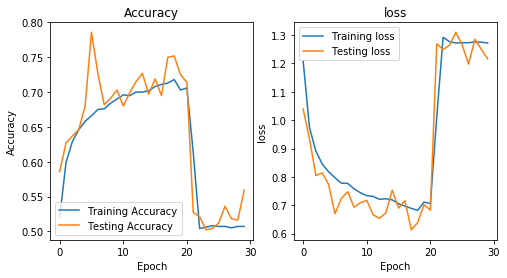



CONFIG: lr_0.02505.dropout_0.5.num_layer_1.hidden_dim_128 

Saving model checkpoint as 0.588 is more than 0
Saving model checkpoint as 0.613 is more than 0.588
Saving model checkpoint as 0.65 is more than 0.613
Saving model checkpoint as 0.68 is more than 0.65
Saving model checkpoint as 0.682 is more than 0.68
Saving model checkpoint as 0.701 is more than 0.682
Saving model checkpoint as 0.725 is more than 0.701
Saving model checkpoint as 0.732 is more than 0.725

Epoch 10/30: 
Training Loss: 0.754, Training Accuracy: 0.687
Validation loss: 0.714, Val accuracy: 0.721
Saving model checkpoint as 0.786 is more than 0.732

Epoch 20/30: 
Training Loss: 1.288, Training Accuracy: 0.5
Validation loss: 1.285, Val accuracy: 0.49

Epoch 30/30: 
Training Loss: 1.27, Training Accuracy: 0.505
Validation loss: 1.296, Val accuracy: 0.49


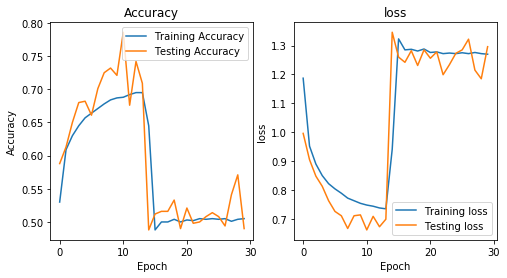



CONFIG: lr_0.02505.dropout_0.25.num_layer_2.hidden_dim_64 

Saving model checkpoint as 0.551 is more than 0
Saving model checkpoint as 0.607 is more than 0.551
Saving model checkpoint as 0.643 is more than 0.607
Saving model checkpoint as 0.68 is more than 0.643
Saving model checkpoint as 0.719 is more than 0.68
Saving model checkpoint as 0.804 is more than 0.719

Epoch 10/30: 
Training Loss: 0.755, Training Accuracy: 0.687
Validation loss: 0.765, Val accuracy: 0.674

Epoch 20/30: 
Training Loss: 0.722, Training Accuracy: 0.701
Validation loss: 0.686, Val accuracy: 0.732

Epoch 30/30: 
Training Loss: 1.24, Training Accuracy: 0.51
Validation loss: 1.218, Val accuracy: 0.525


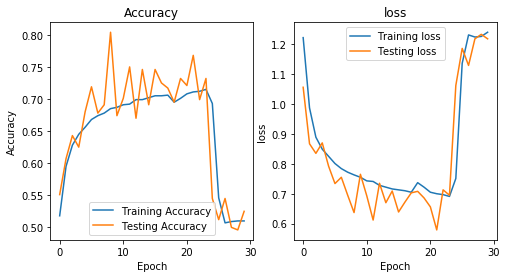



CONFIG: lr_0.02505.dropout_0.5.num_layer_2.hidden_dim_64 

Saving model checkpoint as 0.536 is more than 0
Saving model checkpoint as 0.661 is more than 0.536
Saving model checkpoint as 0.67 is more than 0.661
Saving model checkpoint as 0.676 is more than 0.67
Saving model checkpoint as 0.717 is more than 0.676

Epoch 10/30: 
Training Loss: 0.777, Training Accuracy: 0.677
Validation loss: 0.741, Val accuracy: 0.688
Saving model checkpoint as 0.719 is more than 0.717
Saving model checkpoint as 0.732 is more than 0.719

Epoch 20/30: 
Training Loss: 0.771, Training Accuracy: 0.679
Validation loss: 0.774, Val accuracy: 0.684
Saving model checkpoint as 0.759 is more than 0.732
Saving model checkpoint as 0.795 is more than 0.759

Epoch 30/30: 
Training Loss: 0.695, Training Accuracy: 0.713
Validation loss: 0.602, Val accuracy: 0.766


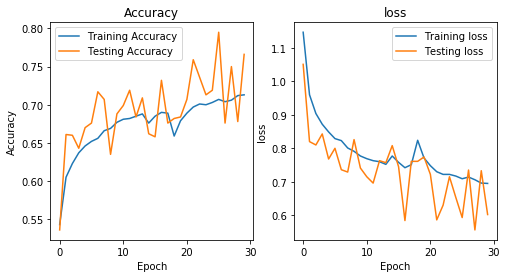



CONFIG: lr_0.02505.dropout_0.25.num_layer_2.hidden_dim_128 

Saving model checkpoint as 0.518 is more than 0
Saving model checkpoint as 0.625 is more than 0.518
Saving model checkpoint as 0.696 is more than 0.625
Saving model checkpoint as 0.723 is more than 0.696

Epoch 10/30: 
Training Loss: 0.729, Training Accuracy: 0.697
Validation loss: 0.607, Val accuracy: 0.766
Saving model checkpoint as 0.766 is more than 0.723
Saving model checkpoint as 0.795 is more than 0.766

Epoch 20/30: 
Training Loss: 0.688, Training Accuracy: 0.716
Validation loss: 0.584, Val accuracy: 0.766
Saving model checkpoint as 0.804 is more than 0.795
Saving model checkpoint as 0.83 is more than 0.804

Epoch 30/30: 
Training Loss: 0.631, Training Accuracy: 0.74
Validation loss: 0.574, Val accuracy: 0.764


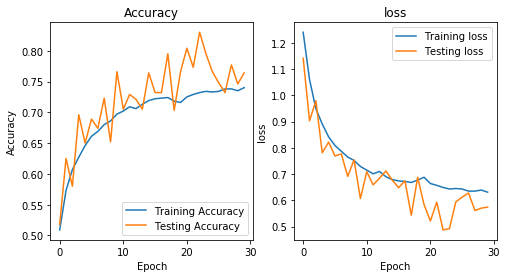



CONFIG: lr_0.02505.dropout_0.5.num_layer_2.hidden_dim_128 

Saving model checkpoint as 0.623 is more than 0
Saving model checkpoint as 0.68 is more than 0.623
Saving model checkpoint as 0.696 is more than 0.68
Saving model checkpoint as 0.75 is more than 0.696
Saving model checkpoint as 0.83 is more than 0.75

Epoch 10/30: 
Training Loss: 0.74, Training Accuracy: 0.693
Validation loss: 0.696, Val accuracy: 0.741

Epoch 20/30: 
Training Loss: 1.068, Training Accuracy: 0.561
Validation loss: 1.072, Val accuracy: 0.555

Epoch 30/30: 
Training Loss: 1.053, Training Accuracy: 0.565
Validation loss: 1.003, Val accuracy: 0.578


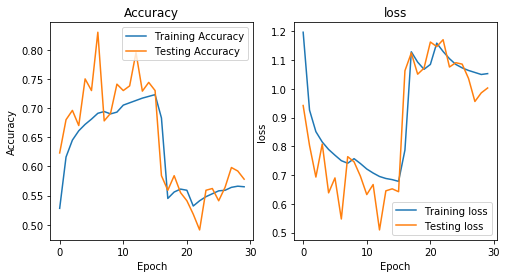



CONFIG: lr_0.05.dropout_0.25.num_layer_1.hidden_dim_64 

Saving model checkpoint as 0.559 is more than 0
Saving model checkpoint as 0.633 is more than 0.559
Saving model checkpoint as 0.641 is more than 0.633
Saving model checkpoint as 0.645 is more than 0.641
Saving model checkpoint as 0.705 is more than 0.645
Saving model checkpoint as 0.732 is more than 0.705

Epoch 10/30: 
Training Loss: 0.849, Training Accuracy: 0.646
Validation loss: 0.796, Val accuracy: 0.662

Epoch 20/30: 
Training Loss: 0.866, Training Accuracy: 0.635
Validation loss: 0.66, Val accuracy: 0.732

Epoch 30/30: 
Training Loss: 1.275, Training Accuracy: 0.505
Validation loss: 1.293, Val accuracy: 0.51


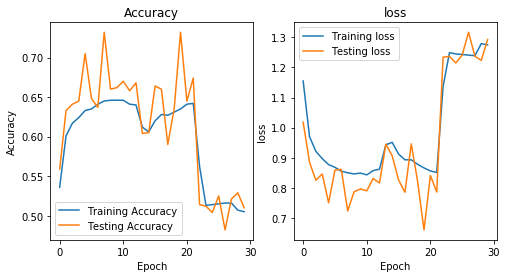



CONFIG: lr_0.05.dropout_0.5.num_layer_1.hidden_dim_64 

Saving model checkpoint as 0.521 is more than 0
Saving model checkpoint as 0.582 is more than 0.521
Saving model checkpoint as 0.621 is more than 0.582
Saving model checkpoint as 0.664 is more than 0.621

Epoch 10/30: 
Training Loss: 0.915, Training Accuracy: 0.622
Validation loss: 0.905, Val accuracy: 0.635
Saving model checkpoint as 0.688 is more than 0.664

Epoch 20/30: 
Training Loss: 1.306, Training Accuracy: 0.506
Validation loss: 1.32, Val accuracy: 0.477

Epoch 30/30: 
Training Loss: 1.3, Training Accuracy: 0.507
Validation loss: 1.258, Val accuracy: 0.52


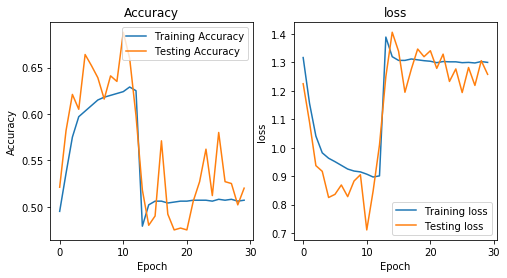



CONFIG: lr_0.05.dropout_0.25.num_layer_1.hidden_dim_128 

Saving model checkpoint as 0.475 is more than 0
Saving model checkpoint as 0.482 is more than 0.475
Saving model checkpoint as 0.661 is more than 0.482
Saving model checkpoint as 0.67 is more than 0.661

Epoch 10/30: 
Training Loss: 0.918, Training Accuracy: 0.612
Validation loss: 0.889, Val accuracy: 0.643
Saving model checkpoint as 0.674 is more than 0.67
Saving model checkpoint as 0.678 is more than 0.674

Epoch 20/30: 
Training Loss: 0.825, Training Accuracy: 0.65
Validation loss: 0.862, Val accuracy: 0.605
Saving model checkpoint as 0.686 is more than 0.678
Saving model checkpoint as 0.715 is more than 0.686

Epoch 30/30: 
Training Loss: 0.755, Training Accuracy: 0.682
Validation loss: 0.526, Val accuracy: 0.804
Saving model checkpoint as 0.804 is more than 0.715


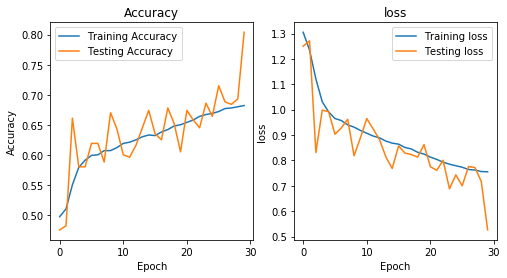



CONFIG: lr_0.05.dropout_0.5.num_layer_1.hidden_dim_128 

Saving model checkpoint as 0.533 is more than 0
Saving model checkpoint as 0.574 is more than 0.533
Saving model checkpoint as 0.616 is more than 0.574
Saving model checkpoint as 0.625 is more than 0.616
Saving model checkpoint as 0.637 is more than 0.625
Saving model checkpoint as 0.652 is more than 0.637
Saving model checkpoint as 0.68 is more than 0.652

Epoch 10/30: 
Training Loss: 0.861, Training Accuracy: 0.641
Validation loss: 0.831, Val accuracy: 0.65
Saving model checkpoint as 0.741 is more than 0.68

Epoch 20/30: 
Training Loss: 1.369, Training Accuracy: 0.475
Validation loss: 1.246, Val accuracy: 0.509

Epoch 30/30: 
Training Loss: 1.301, Training Accuracy: 0.499
Validation loss: 1.25, Val accuracy: 0.525


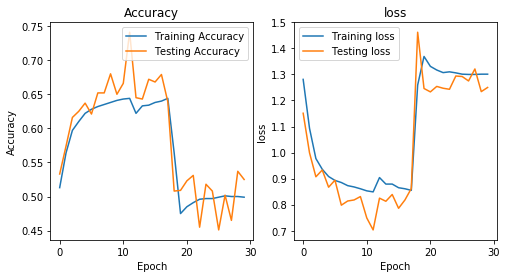



CONFIG: lr_0.05.dropout_0.25.num_layer_2.hidden_dim_64 

Saving model checkpoint as 0.508 is more than 0
Saving model checkpoint as 0.512 is more than 0.508
Saving model checkpoint as 0.514 is more than 0.512
Saving model checkpoint as 0.545 is more than 0.514

Epoch 10/30: 
Training Loss: 1.094, Training Accuracy: 0.552
Validation loss: 1.022, Val accuracy: 0.551
Saving model checkpoint as 0.551 is more than 0.545
Saving model checkpoint as 0.555 is more than 0.551
Saving model checkpoint as 0.566 is more than 0.555
Saving model checkpoint as 0.619 is more than 0.566
Saving model checkpoint as 0.621 is more than 0.619

Epoch 20/30: 
Training Loss: 0.981, Training Accuracy: 0.598
Validation loss: 0.927, Val accuracy: 0.617
Saving model checkpoint as 0.637 is more than 0.621

Epoch 30/30: 
Training Loss: 0.976, Training Accuracy: 0.598
Validation loss: 0.97, Val accuracy: 0.592


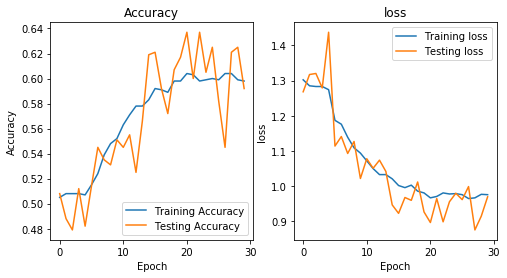



CONFIG: lr_0.05.dropout_0.5.num_layer_2.hidden_dim_64 

Saving model checkpoint as 0.584 is more than 0
Saving model checkpoint as 0.662 is more than 0.584

Epoch 10/30: 
Training Loss: 1.283, Training Accuracy: 0.509
Validation loss: 1.263, Val accuracy: 0.523

Epoch 20/30: 
Training Loss: 1.274, Training Accuracy: 0.509
Validation loss: 1.264, Val accuracy: 0.527

Epoch 30/30: 
Training Loss: 1.221, Training Accuracy: 0.511
Validation loss: 1.189, Val accuracy: 0.518


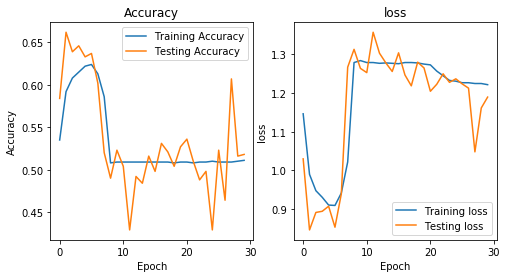



CONFIG: lr_0.05.dropout_0.25.num_layer_2.hidden_dim_128 

Saving model checkpoint as 0.416 is more than 0
Saving model checkpoint as 0.555 is more than 0.416
Saving model checkpoint as 0.57 is more than 0.555
Saving model checkpoint as 0.574 is more than 0.57
Saving model checkpoint as 0.576 is more than 0.574
Saving model checkpoint as 0.58 is more than 0.576

Epoch 10/30: 
Training Loss: 1.061, Training Accuracy: 0.565
Validation loss: 1.048, Val accuracy: 0.572
Saving model checkpoint as 0.588 is more than 0.58
Saving model checkpoint as 0.611 is more than 0.588
Saving model checkpoint as 0.652 is more than 0.611

Epoch 20/30: 
Training Loss: 1.033, Training Accuracy: 0.575
Validation loss: 0.999, Val accuracy: 0.592

Epoch 30/30: 
Training Loss: 1.037, Training Accuracy: 0.576
Validation loss: 0.957, Val accuracy: 0.592


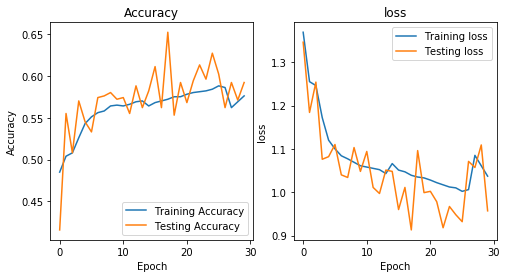



CONFIG: lr_0.05.dropout_0.5.num_layer_2.hidden_dim_128 

Saving model checkpoint as 0.568 is more than 0
Saving model checkpoint as 0.602 is more than 0.568
Saving model checkpoint as 0.617 is more than 0.602
Saving model checkpoint as 0.637 is more than 0.617

Epoch 10/30: 
Training Loss: 1.175, Training Accuracy: 0.534
Validation loss: 1.15, Val accuracy: 0.551

Epoch 20/30: 
Training Loss: 1.058, Training Accuracy: 0.573
Validation loss: 0.952, Val accuracy: 0.619

Epoch 30/30: 
Training Loss: 1.069, Training Accuracy: 0.569
Validation loss: 1.079, Val accuracy: 0.509


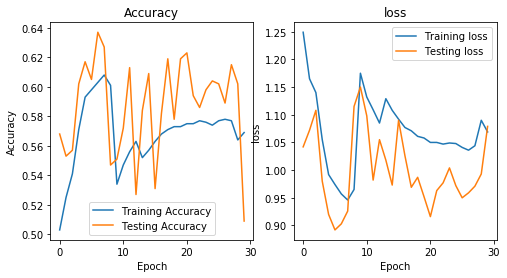

In [32]:
for lr in learning_rates:
  for num_layer in num_layers:
    for hidden_dim in hidden_size:
      for dropout in dropouts:
        history = init_his()
        model = LSTM_Model(vocab_vector=vocab_vector, hidden_dim=hidden_dim, output_dim=5, num_layers=num_layer, dropout=dropout, padding_idx=padding_idx)
        model = model.to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        NAME = f"lr_{lr}.dropout_{dropout}.num_layer_{num_layer}.hidden_dim_{hidden_dim}"
        print("\n\nCONFIG:",NAME,"\n")
        train_fn(model, train_iterator, valid_iterator, opt=opt, criterion=criterion, best_acc=0, epochs=30, NAME=NAME)
        draw_plots(NAME, history)

### Running on best param

```
BEST PARAMS: 
lr  - 1e-4
droput - 0.5
num_layer - 2
hidden_dim - 128
```

In [0]:
model = LSTM_Model(vocab_vector=vocab_vector, hidden_dim=128, output_dim=5, num_layers=2, dropout=0.5, padding_idx=padding_idx)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [36]:
history = init_his()
train_fn(model, train_iterator, valid_iterator, opt=opt, criterion=criterion, best_acc=0, epochs=100, NAME="BEST_MODEL")

Saving model checkpoint as 0.498 is more than 0
Saving model checkpoint as 0.541 is more than 0.498
Saving model checkpoint as 0.543 is more than 0.541
Saving model checkpoint as 0.592 is more than 0.543
Saving model checkpoint as 0.598 is more than 0.592

Epoch 10/100: 
Training Loss: 1.011, Training Accuracy: 0.578
Validation loss: 0.98, Val accuracy: 0.625
Saving model checkpoint as 0.625 is more than 0.598
Saving model checkpoint as 0.656 is more than 0.625

Epoch 20/100: 
Training Loss: 0.922, Training Accuracy: 0.62
Validation loss: 0.867, Val accuracy: 0.654
Saving model checkpoint as 0.666 is more than 0.656

Epoch 30/100: 
Training Loss: 0.859, Training Accuracy: 0.642
Validation loss: 0.82, Val accuracy: 0.652
Saving model checkpoint as 0.672 is more than 0.666
Saving model checkpoint as 0.711 is more than 0.672
Saving model checkpoint as 0.732 is more than 0.711

Epoch 40/100: 
Training Loss: 0.805, Training Accuracy: 0.666
Validation loss: 0.711, Val accuracy: 0.732
Saving 

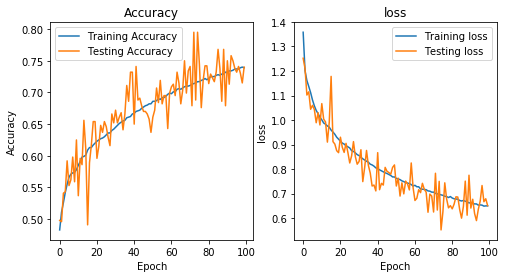

In [37]:
draw_plots("BEST_MODEL", history)

# Predict

In [0]:
def gen_pred(model, test_iterator, savefile=None):
  model.eval()
  tkt = tqdm(test_iterator, total=int(len(test_iterator)))
  predictions = []
  key = []
  if savefile:
    model_state = torch.load(savefile)
    model.load_state_dict(model_state["model_state_dict"])
  for sample_batched in tkt:
    phrase = sample_batched.Phrase
    sentenceid = sample_batched.PhraseId
    pred = model(phrase.to(device)).cpu().detach().numpy()
    predictions.append(pred)
    key.append(sentenceid.cpu().detach().numpy())
  key = flatten_list(key)
  pred = np.argmax(flatten_list(predictions).reshape(-1, 5), axis=-1)
  return key, np.array(Sentiment.vocab.itos)[pred].astype(np.int)   

In [0]:
submit = pd.read_csv("sampleSubmission.csv")

In [40]:
submit.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [0]:
key, pred = gen_pred(model, test_iterator, savefile=None)

In [0]:
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1)   
    z = [x for _, x in sorted(zipped_pairs)] 
    return z

In [0]:
submit.Sentiment = sort_list(pred, key)

In [45]:
submit.Sentiment.value_counts()

2    36415
1    13149
3    11254
4     3257
0     2217
Name: Sentiment, dtype: int64

In [0]:
submit.to_csv("submit.csv", index = False)

In [47]:
!kaggle competitions submit -c sentiment-analysis-on-movie-reviews -f submit.csv -m "Message"

100% 583k/583k [00:06<00:00, 88.5kB/s]
Successfully submitted to Sentiment Analysis on Movie Reviews

## TEST ACCURACY ACHIVED: 63.6%